In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


# PREPROCESSING DATA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PTDLKD/Data/Gold_Data.csv')
df = df[['Price']]
# Format column Price to float
df['Price'] = df.Price.str.replace(',','').astype(float)

# Flip the column
df = df.iloc[::-1]

# Drop missing values
df = df.dropna()

# Reset the index
df = df.reset_index(drop=True)

# SPLITTING DATA(7-2-1)

In [ ]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
!pip install pmdarima --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.1 MB/s eta 0:00:00


In [ ]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', stepwise=True, suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8354.595, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8356.328, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8356.341, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8353.531, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8356.989, Time=0.74 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.370 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1765.7 1765.7 1765.7 1765.7 1765.7 1765.7 1765.7 1765.7 1765.7 1765.7
 1765.7 1765.7 1765.7 1765.7 1765.7 1765.7 1765.7 1765.7 1765.7 1765.7
 1765.7 1765.7 1765.7 1765.7 1765.7 1765.7 1765.7 1765.7 1765.7 1765.7]


In [ ]:
# Calculate the accuracy for each model

from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  94.86136097455092
Testing MAE:  76.47395104895104
Testing MAPE:  4.165457147561865
Validation RMSE:  167.3494199812343
Validation MAE:  146.69930555555553
Validation MAPE:  7.506421482769941


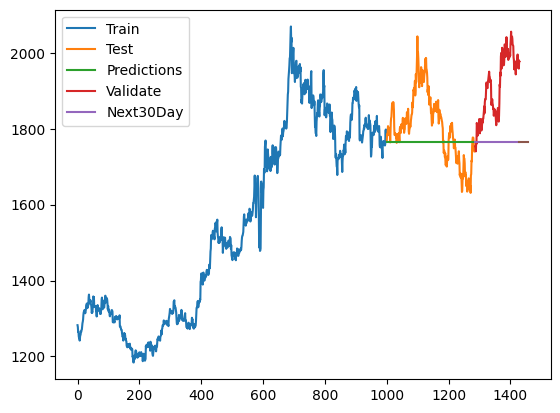

In [ ]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Price'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4175.766
Date:                Mon, 19 Jun 2023   AIC                           8353.531
Time:                        11:03:12   BIC                           8358.438
Sample:                             0   HQIC                          8355.396
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       250.1400      5.135     48.717      0.000     240.077     260.204
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):              2450.88
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               5.66   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SPLITTING DATA(6-3-1)

In [ ]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7154.068, Time=2.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7168.187, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7169.774, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7169.811, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7167.062, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7170.956, Time=0.67 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7171.484, Time=0.49 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7148.907, Time=1.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7161.670, Time=0.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7150.348, Time=1.80 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=7150.062, Time=3.31 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=7159.027, Time=4.26 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=7150.340, Time=6.43 sec
 ARIMA(2,1,3)(0,0,0)[0]             : 

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1713.77585882 1716.15279497 1717.65930045 1718.45405202 1718.33582844
 1717.45474932 1716.15172699 1714.84808571 1713.91488576 1713.57347157
 1713.85033939 1714.59286617 1715.53413276 1716.38253422 1716.90771482
 1716.99881067 1716.6817316  1716.09545519 1715.43897387 1714.90749759
 1714.63735112 1714.67420918 1714.9709226  1715.41202065 1715.85473097
 1716.17287099 1716.29077698 1716.1988045  1715.94818968 1715.62919816]


In [ ]:
# Calculate accurary for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  115.9000112127744
Testing MAE:  96.97576407617007
Testing MAPE:  5.25400706745396
Validation RMSE:  213.15912108298832
Validation MAE:  197.08174109612847
Validation MAPE:  10.140510805271337


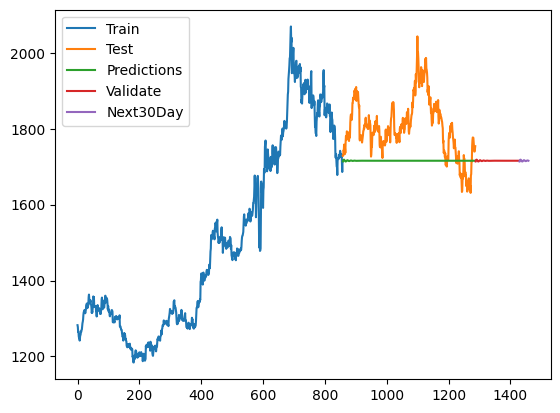

In [ ]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

# SPLITTING DATA(5-3-2)

In [ ]:
# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5844.303, Time=3.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5857.447, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5859.310, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5859.323, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5858.419, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5860.735, Time=0.73 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5861.249, Time=0.57 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5842.851, Time=1.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5853.059, Time=0.80 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5844.660, Time=1.82 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5844.772, Time=1.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5843.059, Time=0.89 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5848.139, Time=0.90 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5846.626, Time=2.64 sec
 ARIMA(3,1,2)(0,0,0)[0]          

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True)

In [ ]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1958.17875067 1962.34499378 1965.22552275 1966.57780907 1966.47782583
 1965.39911817 1964.01943583 1963.01174308 1962.861782   1963.76001132
 1965.58761663 1967.98837442 1970.49585082 1972.67428209 1974.2330941
 1975.08730629 1975.3543257  1975.2961409  1975.22961349 1975.43333245
 1976.07678844 1977.18826354 1978.66521059 1980.31886494 1981.93658281
 1983.34269449 1984.44152198 1985.23315049 1985.80115305 1986.27919316]


In [ ]:
# Calculate accuracy for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  353.7285807819557
Testing MAE:  327.81042425109507
Testing MAPE:  18.008775673061276
Validation RMSE:  274.79595036240573
Validation MAE:  262.46621748514985
Validation MAPE:  14.567283680159077


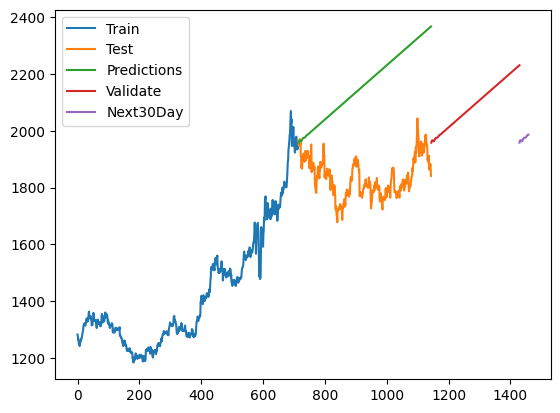

In [ ]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

# Evaluating model

---


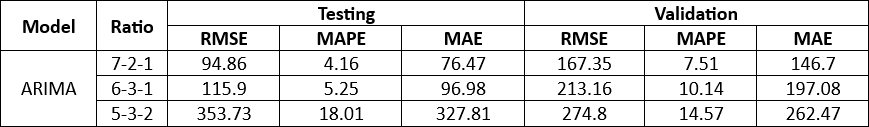